In [153]:
# Generate project token here

In [154]:
# data analysis

import pandas as pd
import numpy as np
import random 
import math

In [155]:
# visualization 

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

In [156]:
# machine learning

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# 1.0 Data Import and Discovery

The data has split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set includes our target variable(dependent variable), passenger survival status(also known as the ground truth from the Titanic tragedy) along with other independent features like gender, class, fare, and Pclass.

The test set should be used to see how well our model performs on unseen data. When we say unseen data, we mean that the algorithm or machine learning models have no relation to the test data. We do not want to use any part of the test data in any way to modify our algorithms; Which are the reasons why we clean our test data and train data separately. The test set does not provide passengers survival status. We are going to use our model to predict passenger survival status.

## Training data

In [157]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_7c85efd21adb4ce8a8f60643abdd5e94 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='LiZHhgRfUEJCTVH4X2dUIlMWd4wi1If3rRkc8cgc-5Ha',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu.cloud-object-storage.appdomain.cloud')

body = client_7c85efd21adb4ce8a8f60643abdd5e94.get_object(Bucket='cvutdsworkshop-donotdelete-pr-uacyrie9pykb6o',Key='train.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

train = pd.read_csv(body)
train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [158]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [159]:
train.shape

(891, 12)

In [160]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Test data

In [161]:

body = client_7c85efd21adb4ce8a8f60643abdd5e94.get_object(Bucket='cvutdsworkshop-donotdelete-pr-uacyrie9pykb6o',Key='test.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

test = pd.read_csv(body)
test.head()

passengerid = test.PassengerId

In [162]:
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [163]:
test.shape

(418, 11)

In [164]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# 2.0 Data Cleaning

We ahve different types of data as well as some of them are missing.

In [165]:
# Function that print total percentage of missing values

def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = round(df.isnull().sum().sort_values(ascending=False)/len(df)*100,2)
    return pd.concat([total,percent], axis=1, keys = ['Total', 'Percent'])

#### missing values in train data

In [166]:
missing_percentage(train)

,Total,Percent
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
PassengerId,0,0.00
Survived,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
SibSp,0,0.00
Parch,0,0.00


#### missing values in test data

In [167]:
missing_percentage(test)

,Total,Percent
Cabin,327,78.23
Age,86,20.57
Fare,1,0.24
PassengerId,0,0.00
Pclass,0,0.00
Name,0,0.00
Sex,0,0.00
SibSp,0,0.00
Parch,0,0.00
Ticket,0,0.00


We have missing data in both tran and test dataset, we need to handle this.

In [168]:
# Lest define percentage of the value counts specific feature

def percent_value_counts(df,feature):
    
    percent = pd.DataFrame(round(df.loc[:,feature].value_counts(dropna=False, normalize=True)*100,2))
    
    total = pd.DataFrame(df.loc[:,feature].value_counts(dropna=False))
    
    total.columns = ['Total']
    percent.columns = ['Percent']
    return pd.concat([total,percent],axis=1)

## 2.1 Embarked

In [169]:
percent_value_counts(train,'Embarked')

,Total,Percent
S,644,72.28
C,168,18.86
Q,77,8.64
NaN,2,0.22


It looks like there are only two null values in Embarked column, we can replace them with mode value, which is 'S'. Let's explore these values in more detail.

In [170]:
train[train.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


We may be able to find the right value for Embarked column based on values of other features. Both passangers payed $80 for tickets, are of Pcalss =1 and female. We can check distribution of Fare among all Pclass and Embarked features.

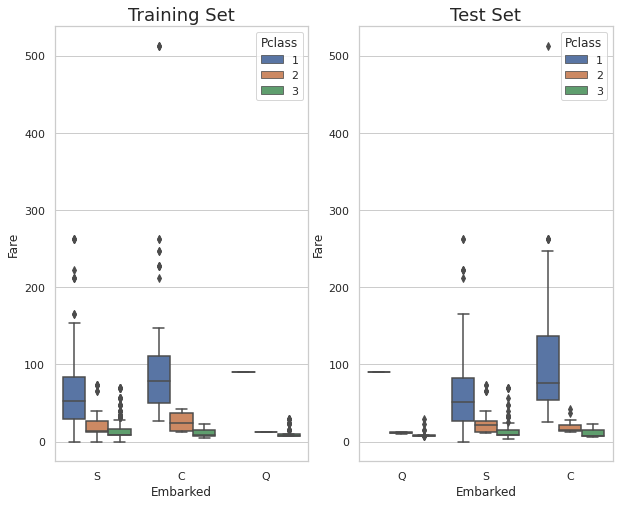

In [171]:
fig, ax = plt.subplots(figsize=(10,8),ncols=2)
ax1 = sns.boxplot(x = 'Embarked', y= 'Fare', hue='Pclass', data = train, ax = ax[0])
ax2 = sns.boxplot(x = 'Embarked', y= 'Fare', hue='Pclass', data = test, ax = ax[1])
ax1.set_title('Training Set', fontsize = 18)
ax2.set_title('Test Set', fontsize = 18)
fig.show()

Here, in both training set and test set, the average fare closest to $80 are in the C Embarked values where pclass is 1. So, let's fill in the missing values as "C"

In [172]:
train.Embarked.fillna('C', inplace = True)

## 2.2 Cabin

In [173]:
print('Train Cabin missing: ' + str(train.Cabin.isnull().sum()/len(train.Cabin)) )
print('Test Cabin missing: ' + str(test.Cabin.isnull().sum()/len(test.Cabin)) )

Train Cabin missing: 0.7710437710437711
Test Cabin missing: 0.7822966507177034


More than 70% of values in Cabin feature for both train and test df is missing. We can get rig of this feature or find appropriatw way to filll in missing values (Passanger with cabin record had a higher socio-economic-status than others or were more likely to be taken into consideration when loading into the boat).

In [174]:
# Lets drop the column
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

## 2.3 Fare

There is only one missing value in Fare column

In [175]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S


We can take the average of the Fare to fill Nan value or we can take it one step further and take avreage of the values where Pcalss=3, sex='male' and Embarked='S'

In [176]:
missing_value = test[(test['Pclass']==3) & (test['Sex']=='male') & (test['Embarked']=='S')]['Fare'].mean()
test['Fare'].fillna(missing_value, inplace=True)

## 2.4 Age

In [177]:
print('Train age missin value: ' +str((train['Age'].isnull().sum()/len(train))*100) +str('%'))
print('Test age missin value: ' +str((test['Age'].isnull().sum()/len(test))*100) +str('%'))

Train age missin value: 19.865319865319865%
Test age missin value: 20.574162679425836%


Around 20% of missing data in Age column is missing in both training and test dataset. Hence it's a quite a lot it wouldn;t be wise to fill these values with median. We will use ML model called Random Forest Regressor to impute missing value instead of Null value - will do that in feature engineering section.

# 3.0 Visualization and Feature Relations

Assumptions:

- Gender : more female survived than male
- Pclass : Higher. socio-economic status passenger survived more than others
- Age: Younger passanger survived more than others
- Fare: Passanger with higher fare survvied more than others, potential correlation with Pclass

Let's visualize them

## 3.1 Gender and Survived

Text(0.5, 0, 'Sex')

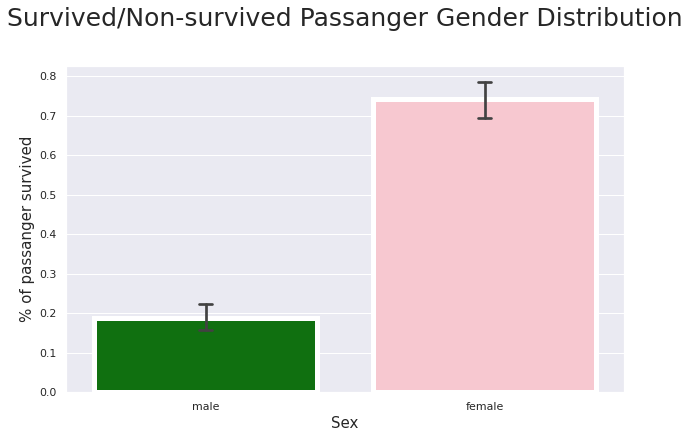

In [178]:
sns.set(style="darkgrid")

palette = {'male':"green", 'female':"Pink"}
plt.subplots(figsize = (10,6))
ax = sns.barplot(x = "Sex", y = "Survived", data=train, palette = palette,linewidth=5,capsize = .05)

plt.title('Survived/Non-survived Passanger Gender Distribution', fontsize=25, loc = 'center', pad = 40)
plt.ylabel('% of passanger survived', fontsize=15)
plt.xlabel("Sex", fontsize=15)

This barplot shows distribution of female and male survived on Titanic. It sows that around 74% of female passanger survived compared to 20% of male passanger who survived.

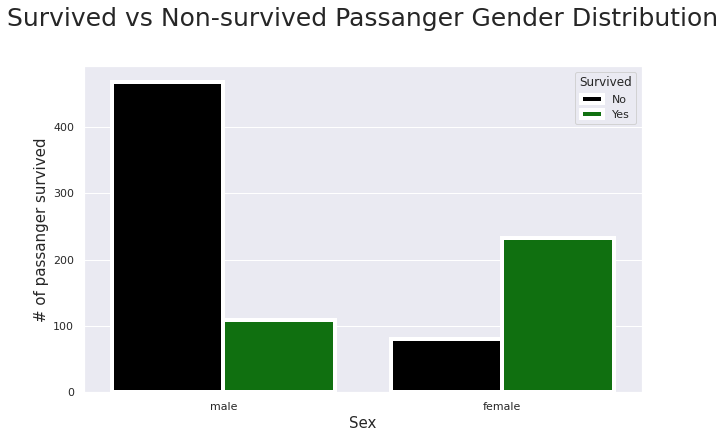

In [179]:
sns.set(style="darkgrid")

palette = {1:"green", 0:"black"}
plt.subplots(figsize = (10,6))
ax = sns.countplot(x = "Sex", hue ='Survived', data=train, palette = palette,linewidth=4)

plt.title('Survived vs Non-survived Passanger Gender Distribution', fontsize=25, loc = 'center', pad = 40)
plt.ylabel('# of passanger survived', fontsize=15)
plt.xlabel("Sex", fontsize=15)

# set legend
leg = ax.get_legend()
leg.set_title("Survived")
legs = leg.texts
legs[0].set_text("No")
legs[1].set_text("Yes")
plt.show()

This countplot is showing actual distribution of number of survied vs non-survied passanged for Gender. Among all the females 230 survived and 70 did not while among male passenges 110 survived and 480 did not survive.

## 3.2 Pclass and Survived

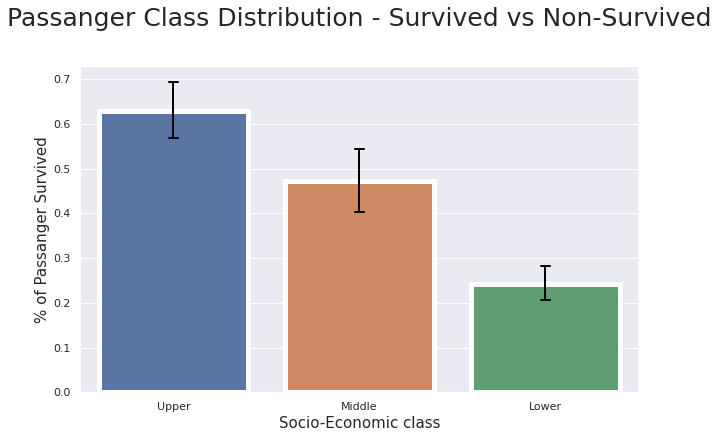

In [180]:
#palette = {1:"green", 0:"black"}
plt.subplots(figsize=(10,6))
ax = sns.barplot(x = 'Pclass', y='Survived', data=train, linewidth=5, capsize=0.05, errcolor='black',errwidth=2)#, palette = palette)

plt.title('Passanger Class Distribution - Survived vs Non-Survived', fontsize=25, pad = 40)
plt.xlabel('Socio-Economic class', fontsize=15)
plt.ylabel('% of Passanger Survived', fontsize=15)
names = ['Upper', 'Middle', 'Lower']
val = [0,1,2]
plt.xticks(val,names)
plt.show()

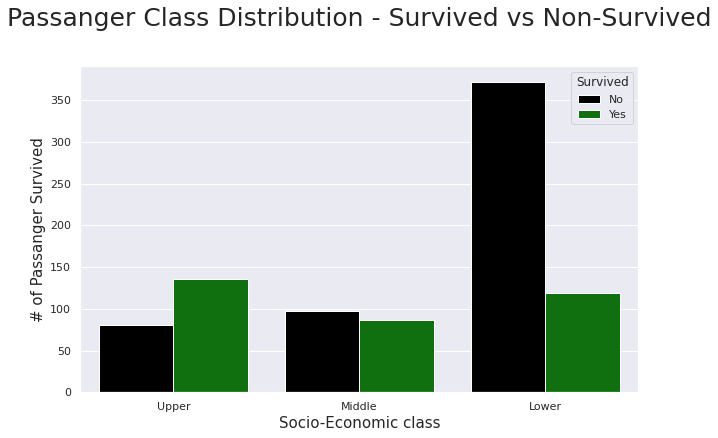

In [181]:
palette = {1:"green", 0:"black"}
plt.subplots(figsize=(10,6))
ax = sns.countplot(x = 'Pclass', hue='Survived', data=train, palette = palette)


leg = ax.get_legend()
leg.set_title("Survived")
legs = leg.texts
legs[0].set_text("No")
legs[1].set_text("Yes")

val=[0,1,2]
names=['Upper', 'Middle', 'Lower']
plt.xticks(val,names)
plt.title('Passanger Class Distribution - Survived vs Non-Survived', fontsize=25, pad = 40)
plt.xlabel('Socio-Economic class', fontsize=15)
plt.ylabel('# of Passanger Survived', fontsize=15)
plt.show()



As we stand in our assumption it's very likely that passanger from Higher socio-economic classes will survived, in comparison with passagers from lower Pclass where more than 350 passanged did not survied comapred to 250 pasanger from Pclass=1 or 2 who survived.

It looks like ...
- 63% first class passenger survived titanic tragedy, while
-  48% second class and
- only 24% third class passenger survived.

## 3.3 Fare and Survived

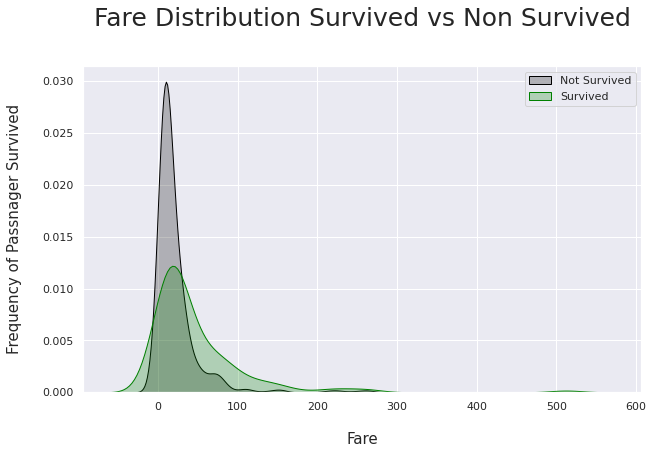

In [182]:
fig = plt.figure(figsize=(10,6))

ax = sns.kdeplot(train.loc[(train['Survived'] == 0), 'Fare'], color = 'black', shade = True, label = 'Not Survived')
ax = sns.kdeplot(train.loc[(train['Survived']==1), 'Fare'],color = 'green', shade = True, label = 'Survived')

plt.title('Fare Distribution Survived vs Non Survived', fontsize=25, pad = 40)
plt.ylabel('Frequency of Passnager Survived', fontsize=15, labelpad = 20)
plt.xlabel('Fare', fontsize=15, labelpad = 20)
plt.legend()
plt.show()

This plot shows two interesting things:
- the spike in the plot under 100 dollar is showing that lot of passnager who bought the ticket within that range did not survive
- when fare is more than 280 dollars either veryone passed that fare point survived or maybe there is an outlier that clouds our judgment

In [183]:
train[train.Fare > 280]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,C


It seems to be and outlier with a fare of $512, we can delete this opints, for now will keep it.

## 3.4 Age and Survived

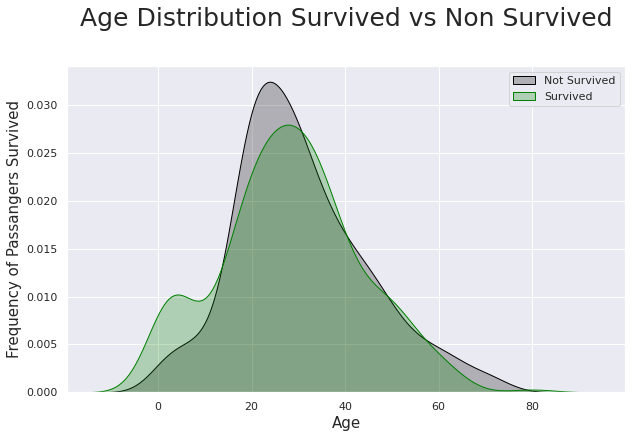

In [184]:
fig = plt.figure(figsize=(10,6))
ax = sns.kdeplot(train.loc[(train['Survived']==0),'Age'], color = 'black', shade = True, label = 'Not Survived')
ax = sns.kdeplot(train.loc[(train['Survived']==1),'Age'], color = 'green', shade = True, label = 'Survived')

plt.title('Age Distribution Survived vs Non Survived',fontsize=25, pad=40)
plt.xlabel('Age', fontsize=15)
plt.ylabel('Frequency of Passangers Survived', fontsize=15)
plt.legend()
plt.show()

Fullfiling our expectations, however the left par may indicate that children and infants were the priority.

# Combined Feature Relations
## 3.5 Survived by Sex and Age

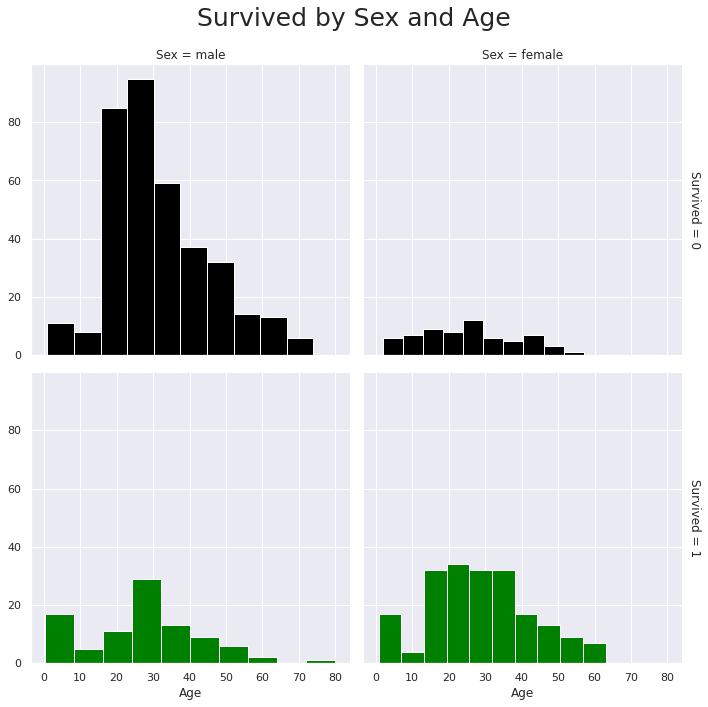

In [185]:
palette = {0:'black', 1:'green'}
ax = sns.FacetGrid(train, size=5, col = 'Sex', row = 'Survived', margin_titles = True, hue = 'Survived', palette = palette)

ax = ax.map(plt.hist, 'Age', edgecolor = 'white')
ax.fig.suptitle('Survived by Sex and Age', size = 25)
plt.subplots_adjust(top=0.90)

Female passangers had higher priority than males, also we can see which age groups had higher chance to survive.

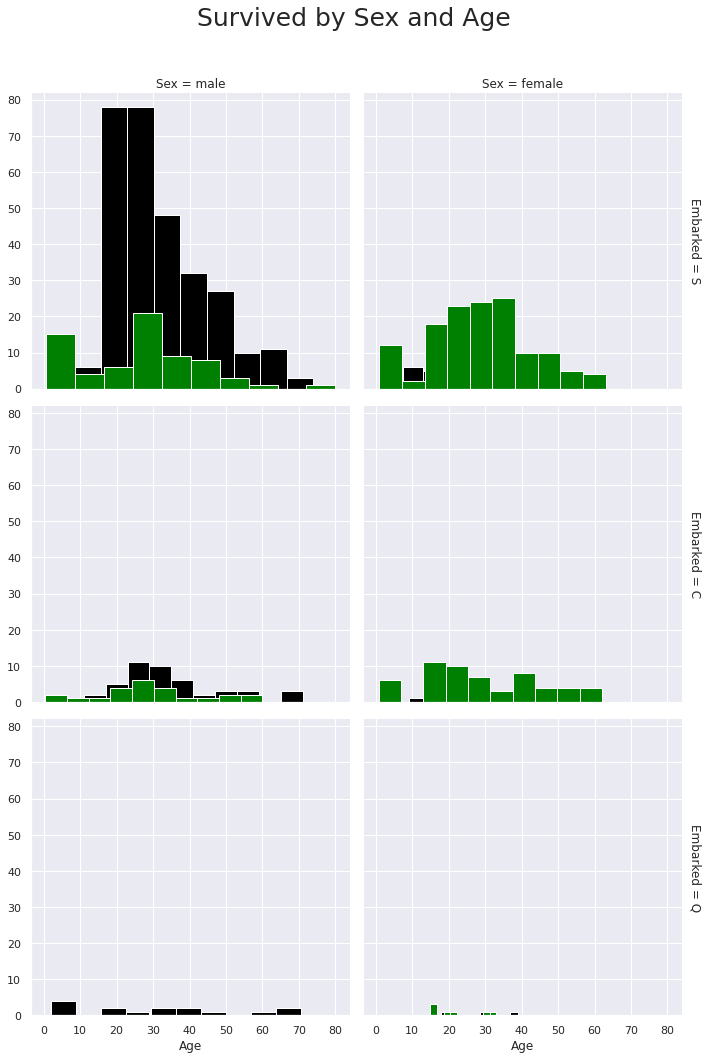

In [186]:
palette = {0:'black', 1:'green'}
ax = sns.FacetGrid(train, size=5, col = 'Sex', row = 'Embarked', margin_titles = True, hue = 'Survived', palette = palette)

ax = ax.map(plt.hist, 'Age', edgecolor = 'white')
ax.fig.suptitle('Survived by Sex and Age', size = 25)
plt.subplots_adjust(top=0.90)

- Most passangers seem to be boarded on Southhampton (S)
- More than 60% of the passengers died boarded on Southhampton
- More than 10% of the passengers lived boarded on Cherbourg (C)
- Almost every man boarded in Queenstown(Q) did not survived
- Very few woman boarded in Queenstown and most of them survived

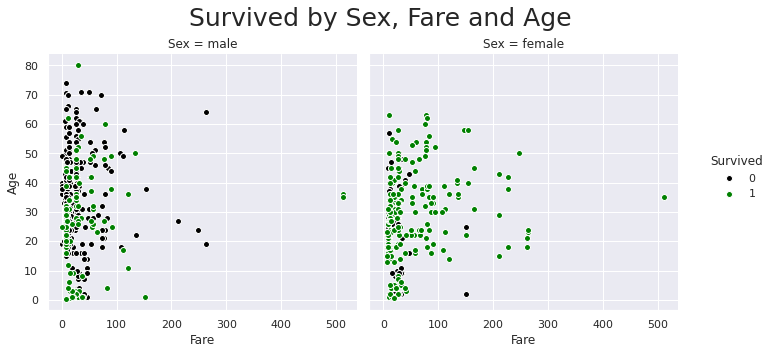

In [187]:
ax = sns.FacetGrid(train , size=5, hue = 'Survived', col = 'Sex', margin_titles = True, palette = palette)
ax.map(plt.scatter, "Fare", 'Age', edgecolor = 'w').add_legend()
ax.fig.suptitle('Survived by Sex, Fare and Age', size = 25)
plt.subplots_adjust(top=0.85)

- We can noticed those 3 outliers with fare > 500 dollars
- Most of the passengers were with in the Fare ranfe of $100  

### Dropping outliers

In [188]:
train = train[train['Fare']<500]

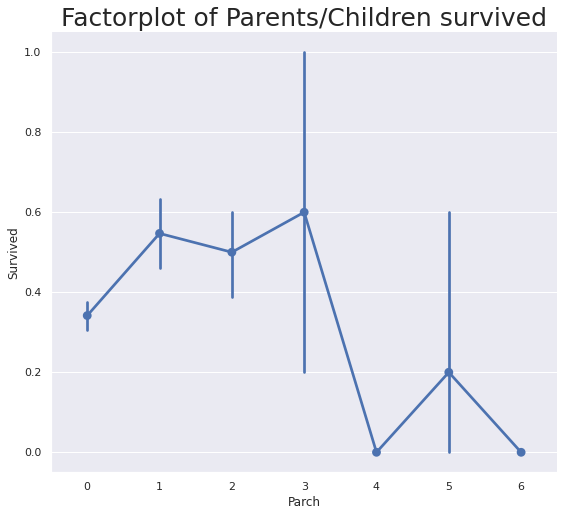

In [189]:
sns.factorplot(x = 'Parch', y = 'Survived', data = train, kind = 'point', size = 8)
plt.title('Factorplot of Parents/Children survived', fontsize=25)
plt.subplots_adjust(top=0.85)

Passengers who traveled in big groups or with parents/children had less survival rate than others.

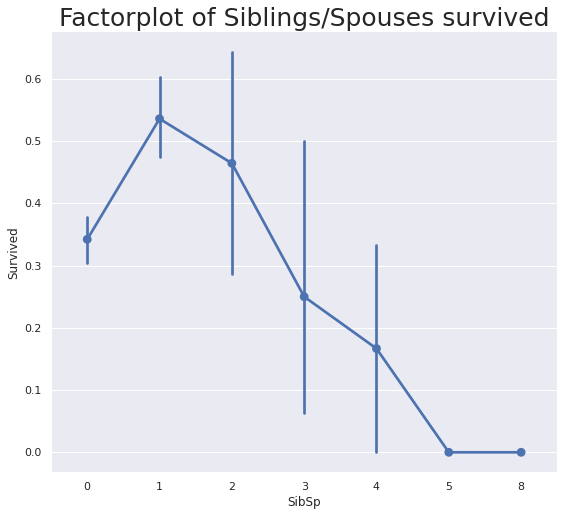

In [190]:
sns.factorplot(x = 'SibSp', y = 'Survived', data = train, kind = 'point', size = 8)
plt.title('Factorplot of Siblings/Spouses survived', fontsize=25)
plt.subplots_adjust(top=0.85)

Passenger who traveled in small groups with sibilings/spouses had better changes of survivint than other passengers.

In [191]:
# Placing 0 for female and 
# 1 for male in the "Sex" column. 
train['Sex'] = train.Sex.apply(lambda x: 0 if x == "female" else 1)
test['Sex'] = test.Sex.apply(lambda x: 0 if x == "female" else 1)

# 4.0 Statistics

In [192]:
train.describe()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
count,888.000000,888.000000,888.000000,888.000000,711.000000,888.000000,888.000000,888.000000
mean,445.618243,0.381757,2.313063,0.647523,29.675345,0.524775,0.381757,30.582164
std,257.405474,0.486091,0.834007,0.478011,14.552495,1.104186,0.806949,41.176366
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,0.000000,2.000000,0.000000,20.000000,0.000000,0.000000,7.895800
50%,445.500000,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200
75%,667.250000,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,30.771850
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,263.000000


In [193]:
train.describe(include='O')

,Name,Ticket,Embarked
count,888,888,888
unique,888,680,3
top,"Braund, Mr. Owen Harris",347082,S
freq,1,7,644


In [194]:
# survived vs non-survived summary
survived_summary = train.groupby('Survived')
survived_summary.mean().reset_index()

,Survived,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,447.016393,2.531876,0.852459,30.626179,0.553734,0.329690,22.117887
1,1,443.353982,1.958702,0.315634,28.270627,0.477876,0.466077,44.289799


In [195]:
# male vs female summary
sex_summary = train.groupby('Sex')
sex_summary.mean().reset_index()

,Sex,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,431.578275,0.741214,2.162939,27.888462,0.696486,0.651757,42.985091
1,1,453.260870,0.186087,2.394783,30.705477,0.431304,0.234783,23.830658


In [196]:
# Pclass summary
pclass_summary = train.groupby('Pclass')
pclass_summary.mean().reset_index()

,Pclass,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare
0,1,460.225352,0.624413,0.563380,38.280984,0.422535,0.356808,78.124061
1,2,445.956522,0.472826,0.586957,29.877630,0.402174,0.380435,20.662183
2,3,439.154786,0.242363,0.706721,25.140620,0.615071,0.393075,13.675550


- only 38% passenger survived during that tragedy (mena value for survived column in describe())
- ~74% female passenger survived, while only ~19% male passenger survived
- ~63% first class passengers survived, while only 24% lower class passenger survived.

## 4.1 Correlation Matrix and Heatmap

In [197]:
pd.DataFrame(abs(train.corr()['Survived']).sort_values(ascending=False))

,Survived
Survived,1.000000
Sex,0.545899
Pclass,0.334068
Fare,0.261742
Parch,0.082157
Age,0.079472
SibSp,0.033395
PassengerId,0.006916


It seems Sex feature is the most correlated feature with Survived (dependent variable) feature followed by Pclass

In [198]:
## get the most important variables. 
corr = train.corr()**2
corr.Survived.sort_values(ascending=False)

Survived       1.000000
Sex            0.298006
Pclass         0.111601
Fare           0.068509
Parch          0.006750
Age            0.006316
SibSp          0.001115
PassengerId    0.000048
Name: Survived, dtype: float64

Squaring the correlation feature not only gives on positive correlations but also amplifies the relationships.

Text(0.5, 1.03, 'Correlation Among features')

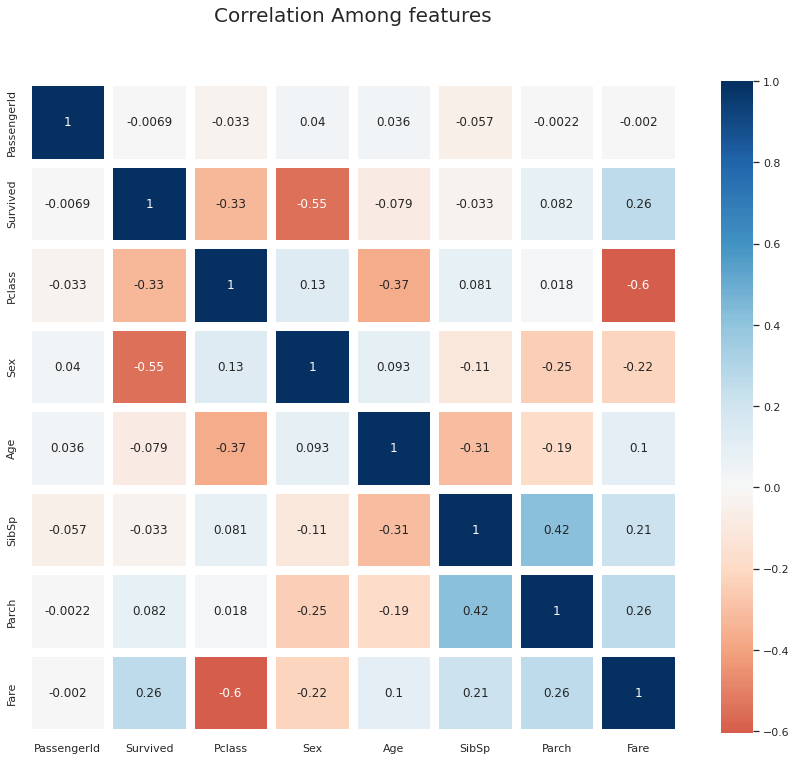

In [199]:
sns.set_style('whitegrid')
plt.subplots(figsize=(15,12))
sns.heatmap(train.corr(), annot = True, cmap = 'RdBu', linewidths = 9, linecolor = 'white', fmt = '.2g', center = 0, square = True)
plt.title('Correlation Among features', y = 1.03, fontsize=20, pad=40)

Positive Correlation Features:
 - Survived and Fare
 
Negative Correlation Features:
- Fare and Pclass
- Survived and Sex
- Survived and Pclass

So, Let's analyze these correlations a bit.

We have found some moderately strong relationships between different features. There is a definite positive correlation between Fare and Survived rated. This relationship reveals that the passenger who paid more money for their ticket were more likely to survive. This theory aligns with one other correlation which is the correlation between Fare and Pclass(-0.6). This relationship can be explained by saying that first class passenger(1) paid more for fare then second class passenger(2), similarly second class passenger paid more than the third class passenger(3). This theory can also be supported by mentioning another Pclass correlation with our dependent variable, Survived. The correlation between Pclass and Survived is -0.33. This can also be explained by saying that first class passenger had a better chance of surviving than the second or the third and so on.

However, the most significant correlation with our dependent variable is the Sex variable, which is the info on whether the passenger was male or female. This negative correlation with a magnitude of -0.54 which points towards some undeniable insights. Let's do some statistics to see how statistically significant this correlation is.

In [200]:
male_mean = train[train['Sex']==1].Survived.mean()

female_mean = train[train['Sex']==0]['Survived'].mean()

print('Male survival mean: ' +str(male_mean))
print('Female survival mean: ' +str(female_mean))

print('The mean difference btw male and female survival rate: ' + str(female_mean - male_mean))

Male survival mean: 0.18608695652173912
Female survival mean: 0.7412140575079872
The mean difference btw male and female survival rate: 0.5551271009862481


Now, we have to understand that those two means are not the population mean ($\mu$) - whole population mean. We will use the sampling distribution approach to do the test. let's take 50 random sample of male and female from our train data.

In [201]:
from statistics import variance

# separating male and female df
male = train[train['Sex']==1]
female = train[train['Sex']==0]

# empty lists for storing mean sample
m_mean_sample = []
f_mean_sample = []
m_variance = []
f_variance = []

for i in range(50):
    m_mean_sample.append(np.mean(random.sample(list(male['Survived']),50)))
    m_variance.append(np.mean(variance(random.sample(list(male['Survived']),50))))
    
    f_mean_sample.append(np.mean(random.sample(list(female['Survived']),50)))
    f_variance.append(np.mean(variance(random.sample(list(female['Survived']),50))))
    
print(f'Male mean sample mean: {round(np.mean(m_mean_sample),2)}' )
print(f'Female mean sample mean: {round(np.mean(f_mean_sample),2)}' )
print(f'The mean difference btw male and female sample mean: {round(np.mean(f_mean_sample) - np.mean(m_mean_sample),2)}')

Male mean sample mean: 0.19
Female mean sample mean: 0.75
The mean difference btw male and female sample mean: 0.56


# 5.0 Feature Engineering

create extra features from with in the features that we have remove features that are alike

## 5.1 Title

In [202]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S


In [203]:
train['title'] = [i.split('.')[0] for i in train['Name']] #splitting name to parts, the value with index=1 is title
train["title"] = [i.split(',')[1] for i in train.title]
train.title = train.title.apply(lambda x: x.strip())

In [204]:
train.title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [205]:
## We can also combile all three lines above for test set here
test['title'] = [i.split('.')[0].split(',')[1].strip() for i in test.Name]

In [206]:
test.title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [207]:
# Let's fix som misspeling and replace rare values with keyword 'rare'
## we are writing a function that can help us modify title column
## we are writing a function that can help us modify title column
def name_converted(feature):
    """
    This function helps modifying the title column
    """
    
    result = ''
    if feature in ['the Countess','Capt','Lady','Sir','Jonkheer','Don','Major','Col', 'Rev', 'Dona', 'Dr']:
        result = 'rare'
    elif feature in ['Ms', 'Mlle']:
        result = 'Miss'
    elif feature == 'Mme':
        result = 'Mrs'
    else:
        result = feature
    return result

test.title = test.title.map(name_converted)
train.title = train.title.map(name_converted)

In [208]:
print(train.title.unique())
print(test.title.unique())

['Mr' 'Mrs' 'Miss' 'Master' 'rare']
['Mr' 'Mrs' 'Miss' 'Master' 'rare']


## 5.2 family_size

In [209]:
train['family_size'] = train['SibSp'] + train['Parch'] + 1
test['family_size'] = test['SibSp'] + test['Parch'] + 1

In [210]:
def family_group(size):
    group = ''
    if size<=1:
        group = 'loner'
    elif size <=4:
        group = 'small'
    else:
        gorup = 'large'
    return group

In [211]:
train['family_group'] = train['family_size'].map(family_group)
test['family_group'] = test['family_size'].map(family_group)

## 5.3 is_alone

In [212]:
train['is_alone'] = [1 if i<2 else 0 for i in train['family_size']]
test['is_alone'] = [1 if i<2 else 0 for i in test['family_size']]

## 5.4 ticket

In [213]:
train['Ticket'].value_counts().sample(10)

S.O.P. 1166    1
2662           1
C 17369        1
236171         1
W/C 14208      1
A./5. 2152     1
28551          1
347742         3
370369         1
330959         1
Name: Ticket, dtype: int64

In [214]:
# we will drop ticket feature from train/test data hence it does not have value for prediction
train.drop('Ticket', axis=1, inplace=True)
test.drop('Ticket', axis=1, inplace=True)

## 5.5 calculated_fare

In [215]:
# calculating fare based on family_size
train['calculated_fare'] = train['Fare']/train['family_size']
test['calculated_fare'] = test['Fare']/test['family_size']

## 5.6 fare_group

In [216]:
def fare_group(fare):
    group = ''
    if fare <=10:
        group = 'very_low'
    elif fare <=20:
        group = 'low'
    elif fare <=30:
        group = 'mid'
    elif fare <=45:
        group = 'high'
    else:
        group = 'very_high'
    return group

train['fare_group'] = train['calculated_fare'].map(fare_group)
test['fare_group'] = test['calculated_fare'].map(fare_group)

## 5.7 PassengerId

In [217]:
# we can drop this columsn hence it's working as ID of passangers and does not bring any value to prediciton of survival

train.drop('PassengerId', axis=1, inplace=True)
test.drop('PassengerId', axis=1, inplace=True)

In [218]:
train.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_size', 'family_group', 'is_alone',
       'calculated_fare', 'fare_group'],
      dtype='object')

# Creating dummy variables


In [219]:
train = pd.get_dummies(train, columns = ['title','Pclass','Embarked','family_group','fare_group'],drop_first=False)
test = pd.get_dummies(test, columns = ['title','Pclass','Embarked','family_group','fare_group'],drop_first=False)

train.drop(['family_size','Name','Fare'],axis=1,inplace=True)
test.drop(['family_size','Name','Fare'],axis=1,inplace=True)

## 5.8 age

As we agreed before, we will fillna using regressor

In [220]:
# rearranging the columns
train = pd.concat([train[['Survived','Age','Sex','SibSp','Parch']], train.loc[:,'is_alone':]],axis=1)
test = pd.concat([test[['Age','Sex']],test.loc[:,'SibSp':]],axis=1)

In [221]:
train.head()

,Survived,Age,Sex,SibSp,Parch,is_alone,calculated_fare,title_Master,title_Miss,title_Mr,...,Embarked_Q,Embarked_S,family_group_,family_group_loner,family_group_small,fare_group_high,fare_group_low,fare_group_mid,fare_group_very_high,fare_group_very_low
0,0,22.0,1,1,0,0,3.62500,0,0,1,...,0,1,0,0,1,0,0,0,0,1
1,1,38.0,0,1,0,0,35.64165,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,1,26.0,0,0,0,1,7.92500,0,1,0,...,0,1,0,1,0,0,0,0,0,1
3,1,35.0,0,1,0,0,26.55000,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,0,35.0,1,0,0,1,8.05000,0,0,1,...,0,1,0,1,0,0,0,0,0,1


In [222]:
# RandomForestRegressor

def completing_age(df):
    age_df = df.loc[:,'Age':]
    
    temp_train = age_df.loc[age_df.Age.notnull()] # df with age values
    temp_test = age_df.loc[age_df.Age.isnull()] # df without age values
    
    y = temp_train.Age.values #target variable is age
    x = temp_train.loc[:,'Sex':].values
    
    rfr = RandomForestRegressor()
    rfr.fit(x,y)
    
    predicted_age = rfr.predict(temp_test.loc[:,"Sex":])
    
    df.loc[df.Age.isnull(),"Age"] = predicted_age
    
    return df

completing_age(train)
completing_age(test)

,Age,Sex,SibSp,Parch,is_alone,calculated_fare,title_Master,title_Miss,title_Mr,title_Mrs,...,Embarked_Q,Embarked_S,family_group_,family_group_loner,family_group_small,fare_group_high,fare_group_low,fare_group_mid,fare_group_very_high,fare_group_very_low
0,34.500000,1,0,0,1,7.829200,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
1,47.000000,0,1,0,0,3.500000,0,0,0,1,...,0,1,0,0,1,0,0,0,0,1
2,62.000000,1,0,0,1,9.687500,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
3,27.000000,1,0,0,1,8.662500,0,0,1,0,...,0,1,0,1,0,0,0,0,0,1
4,22.000000,0,1,1,0,4.095833,0,0,0,1,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,26.716623,1,0,0,1,8.050000,0,0,1,0,...,0,1,0,1,0,0,0,0,0,1
414,39.000000,0,0,0,1,108.900000,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
415,38.500000,1,0,0,1,7.250000,0,0,1,0,...,0,1,0,1,0,0,0,0,0,1
416,26.716623,1,0,0,1,8.050000,0,0,1,0,...,0,1,0,1,0,0,0,0,0,1


<AxesSubplot:xlabel='Age', ylabel='Density'>

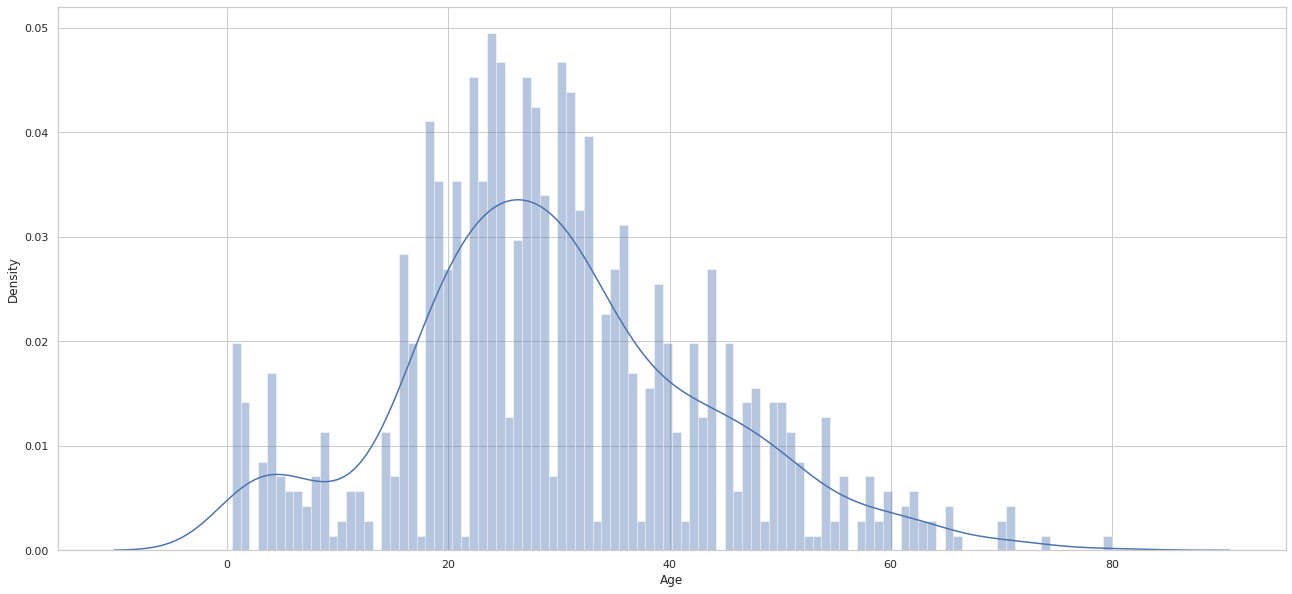

In [223]:
# Let's look at the his
plt.subplots(figsize=(22,10))
sns.distplot(train['Age'],bins=100, kde=True, rug = False, norm_hist=False)

## 5.9 age_group

In [224]:
def age_group(age):
    group = ''
    if age <=1:
        group = 'infant'
    elif age <=4:
        group = 'toddler'
    elif age <=13:
        group = 'child'
    elif age <=18:
        group = 'teenager'
    elif age <=35:
        group = 'young_adult'
    elif age <=45:
        group = 'adult'
    elif age <=55:
        group = 'middle_aged'
    elif age <=65:
        group = 'senior_citizen'
    else:
        group = 'old'
    return group

train['age_group'] = train['Age'].map(age_group)
test['age_group'] = test['Age'].map(age_group)

# creating dummies

train = pd.get_dummies(train, columns =['age_group'], drop_first=True)
test = pd.get_dummies(test, columns =['age_group'], drop_first=True)

# 6.0 Pre-Modeling

When we train the machine learning algorithms, we use part of the training set usually two-thirds of the train data. Once we train our algorithm using 2/3 of the train data, we start to test our algorithms using the remaining data. If the model performs well we dump our test data in the algorithms to predict the real unseen data.

In [231]:
X = train.drop('Survived',axis=1)
y = train['Survived']

In [232]:
train.shape

(888, 34)

In [233]:
X.shape

(888, 33)

## 6.1 Splitting training data

- train_test_split
- cross_validation

In [235]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .33, random_state=0)

## 6.2 Feature Scaling

Feature scaling is an important concept of machine learning models. Often times a dataset contain features highly varying in magnitude and unit. For some machine learning models, it is not a problem. However, for many other ones, its quite a problem. Many machine learning algorithms uses euclidian distances to calculate the distance between two points, it is quite a problem

There are multiple ways to do feature scaling. 
<ul>
    <li><b>MinMaxScaler</b>-Scales the data using the max and min values so that it fits between 0 and 1.</li>
    <li><b>StandardScaler</b>-Scales the data so that it has mean 0 and variance of 1.</li>
    <li><b>RobustScaler</b>-Scales the data similary to Standard Scaler, but makes use of the median and scales using the interquertile range so as to aviod issues with large outliers.</b>
 </ul>
For now we will use <b>Standard Scaler</b> to feature scale our dataset. 


In [237]:
# Feature scaling
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [238]:
pd.DataFrame(X_train, columns=headers).head()

ValueError: Shape of passed values is (594, 33), indices imply (594, 34)

# 7.0 Modeling

In [239]:
# import LogisticRegression model in python. 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

# call on the model object
log_reg = LogisticRegression(solver = 'liblinear', penalty='l1', random_state=42)

# train the model
log_reg.fit(X_train, y_train)

# make predictions
y_pred = log_reg.predict(X_test)

# evaluate predictions
pd.DataFrame(confusion_matrix(y_test,y_pred),columns=['Predicted Not-Survived', 'Predicted Survived'], index = ['Not-Survived','survived'])



,Predicted Not-Survived,Predicted Survived
Not-Survived,146,31
survived,30,87


### Accuracy

In [240]:
# Accuracy is the measure of how often the model is correct
accuracy_score(y_test,y_pred)

0.7925170068027211

### Recall

In [241]:
# How often the model predicts yes(survived) when it's actually yes(survived)?
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.7435897435897436

### Precision

In [242]:
# How often is it correct when the model predicts yes
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

0.7372881355932204

In [243]:
from sklearn.metrics import classification_report, balanced_accuracy_score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       177
           1       0.74      0.74      0.74       117

    accuracy                           0.79       294
   macro avg       0.78      0.78      0.78       294
weighted avg       0.79      0.79      0.79       294



### AUC & ROC Curve

0.839441788594331


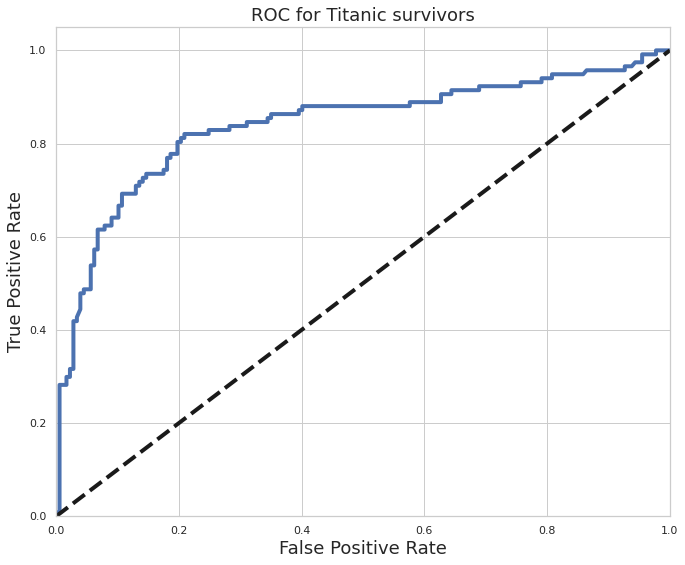

In [244]:
from sklearn.metrics import roc_curve, auc

y_score = log_reg.decision_function(X_test)

FPR, TPR, _ = roc_curve(y_test,y_score)
ROC_AUC = auc(FPR, TPR)
print(ROC_AUC)

plt.figure(figsize=(11,9))
plt.plot(FPR,TPR, label = 'ROC curve (area = %0.2f)'%ROC_AUC, linewidth=4)
plt.plot([0,1],[0,1], 'k--', linewidth=4)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.title('ROC for Titanic survivors', fontsize= 18)
plt.show()

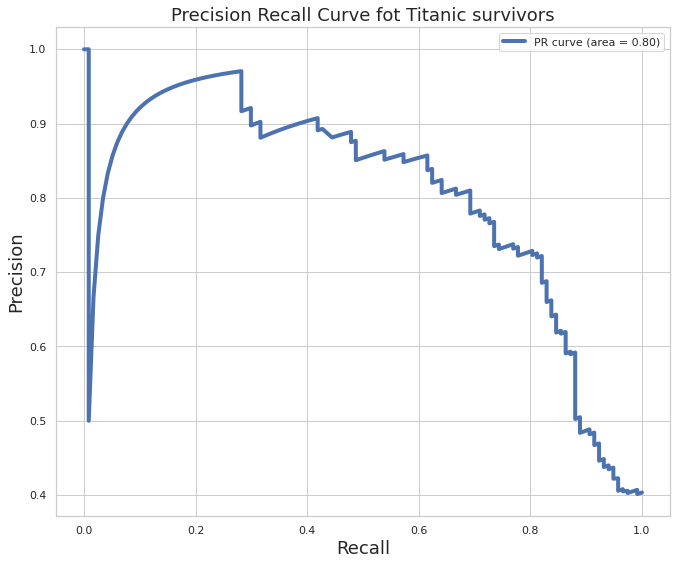

In [245]:
from sklearn.metrics import precision_recall_curve

y_score = log_reg.decision_function(X_test)

precision,recall, _ = precision_recall_curve(y_test,y_score)
PR_AUC = auc(recall, precision)

plt.figure(figsize=(11,9))
plt.plot(recall, precision, label = 'PR curve (area = %0.2f)' %PR_AUC, linewidth=4)
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.title('Precision Recall Curve fot Titanic survivors', fontsize=18)
plt.legend()
plt.show()

## 7.1 Cross-Validation
 
- helps reduce variance
- expends models predictability

In [246]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

cv = StratifiedShuffleSplit(n_splits = 10, test_size = .25, random_state=0) # run model 10x with 60/30 split intentionally leaving out 10%

column_names = X.columns

X = sc.fit_transform(X)
accuracies = cross_val_score(LogisticRegression(solver = 'liblinear'), X, y, cv = cv)
print ("Cross-Validation accuracy scores:{}".format(accuracies))
print ("Mean Cross-Validation accuracy score: {}".format(round(accuracies.mean(),5)))

Cross-Validation accuracy scores:[0.81081081 0.84684685 0.81531532 0.83783784 0.85585586 0.83333333
 0.81081081 0.86486486 0.83783784 0.81531532]
Mean Cross-Validation accuracy score: 0.83288


## 7.2 Grid Search on Logistic Regression

GridSearch searching for optimal parameter/parameters over a "grid." These optimal parameters are also known as Hyperparameters. The Hyperparameters are model parameters that are set before fitting the model and determine the behavior of the model..

In [247]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# C_vals is the alpla value of lasso and ridge regression(as alpha increases the model complexity decreases,)
C_vals = [0.1,0.2,0.5,1,5,10]

# Choosing penalties(Lasso(l1) or Ridge(l2))
penalties = ['l1','l2']

param = {'penalty': penalties, 'C':C_vals}

# choose cross val strategy
cv = StratifiedShuffleSplit(n_splits = 10, test_size = .25)


grid = GridSearchCV(estimator = LogisticRegression(solver = 'liblinear'),
                   param_grid = param,
                   scoring = 'accuracy',
                   n_jobs = -1,
                   cv =cv)
grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.25,
            train_size=None),
             estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.5, 1, 5, 10],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [248]:
# Getting the best of everything. 
print (grid.best_score_)
print (grid.best_params_)
print(grid.best_estimator_)

0.8315315315315315
{'C': 0.2, 'penalty': 'l1'}
LogisticRegression(C=0.2, penalty='l1', solver='liblinear')


In [249]:
log_reg_grid = grid.best_estimator_
log_reg_grid.score(X,y)

0.8333333333333334

## 7.3 K-Nearest Neighbor classifier

In [250]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
## trying out multiple values for k
k_range = range(1,10)
## 
weights_options=['uniform','distance']
# 
param = {'n_neighbors':k_range, 'weights':weights_options}
## Using startifiedShufflesplit. 
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)
# estimator = knn, param_grid = param, n_jobs = -1 to instruct scikit learn to use all available processors. 
grid = GridSearchCV(KNeighborsClassifier(), param,cv=cv,verbose = False, n_jobs=-1)
## Fitting the model. 
grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 10),
                         'weights': ['uniform', 'distance']},
             verbose=False)

In [251]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8044943820224718
{'n_neighbors': 3, 'weights': 'uniform'}
KNeighborsClassifier(n_neighbors=3)


In [252]:
### Using the best parameters from the grid-search.
knn_grid= grid.best_estimator_
knn_grid.score(X,y)

0.8783783783783784

## 7.4 Random Forest Classifier

In [253]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier

n_estimators = [140,150]
max_depth = range(5,10)
criterions = ['gini', 'entropy']
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)


parameters = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'criterion': criterions
              
        }
grid = GridSearchCV(estimator=RandomForestClassifier(max_features='auto'),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 10),
                         'n_estimators': [140, 150]})

In [254]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.8367041198501871
{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 140}
RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=140)


In [255]:
rf_grid = grid.best_estimator_
rf_grid.score(X,y)

0.8412162162162162

# 8.0 Predictions

In [256]:
all_models = [log_reg_grid,
              knn_grid, 
              rf_grid]

c = {}
for i in all_models:
    a = i.predict(X_test)
    b = accuracy_score(a, y_test)
    c[i] = b
test_prediction = (max(c, key=c.get)).predict(test) #select model with best performance and predict on unseen test data

### Predictions on best performing algorithm

In [257]:
final_predictions = pd.DataFrame({
        "PassengerId": passengerid,
        "Survived": test_prediction
    })

final_predictions.PassengerId = final_predictions.PassengerId.astype(int)
final_predictions.Survived = final_predictions.Survived.astype(int)
final_predictions.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


### Save test data to project for OpenScale

In [268]:
# test_w_prediction = test.copy()
# test_w_prediction ['Survived'] =final_predictions['Survived'].values
# project.save_data(data=test_w_prediction.to_csv(index=False), file_name='titanic_test.csv', overwrite=True)

{'file_name': 'titanic_test.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'titanicsurvivalprediction-donotdelete-pr-gnwrpy6ekybh5k',
 'asset_id': '77da1785-e925-48fc-9cc2-60982775bf54'}

In [ ]:
# train_X_ = pd.DataFrame(X, columns=X.columns)
# train_X_['Survived'] = y
# project.save_data(data=train_X_.to_csv(index=False), file_name='titanic_train.csv', overwrite=True)

# 9.0 Deployment

In [139]:
from ibm_watson_machine_learning import APIClient
import os

ibmcloud_api_key='' #your apikey
location = os.environ['RUNTIME_ENV_REGION']

if ibmcloud_api_key != '':
    wml_credentials = {
        "apikey": ibmcloud_api_key,
        "url": 'https://' + location + '.ml.cloud.ibm.com'
   }
else:
    token = os.environ['USER_ACCESS_TOKEN']
    wml_credentials = {
        "token": token,
        "instance_id" : "openshift",
        "url": os.environ['RUNTIME_ENV_APSX_URL'],
        "version": "4.0"
     }
client = APIClient(wml_credentials)

## 9.1 Check out deployment spaces and set default one

In [140]:
client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -------------------------------------------------------------------  ------------------------
ID                                    NAME                                                                 CREATED
27bd27e4-5646-4d8e-b4a6-27a7917343ae  Banking-demo-development                                             2022-03-28T13:17:31.021Z
bd147e5c-b413-464f-a6ed-16f6cbdb57b3  openscale-express-path-preprod-2de92047-d928-44b6-be98-8b0e563109ec  2022-03-28T07:30:16.399Z
88d89355-6756-4e93-a306-676e003c88c3  openscale-express-path-2de92047-d928-44b6-be98-8b0e563109ec          2022-03-28T07:29:45.203Z
9c7d72e5-7331-4282-ac68-d64fff460baa  Auto-ML-deployment                                                   2022-03-24T12:59:45.886Z
29ea854e-f3ac-4e8c-a1b5-7678fc8c24d3  openscale-express-path-preprod-76900f8a-976f-45a0-beef-59dc343c5f08  2022-03-04T1

In [141]:
space_id = '' #define id of a space you created for deployment
client.set.default_space(space_id)

'SUCCESS'

## 9.2 Set up deployment parameters

In [142]:
DEPLOYMENT_SPACE_NAME = 'titanic_survival_prediction'

In [143]:
model_props = {
    client.repository.ModelMetaNames.NAME: 'titanic_survival_pipeline',
    client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: client.software_specifications.get_id_by_name('runtime-22.1-py3.9'),
    client.repository.ModelMetaNames.LABEL_FIELD: 'Survived',

}

## 9.3 Store the model

In [144]:
# create pipeline
steps = [
    ("preprocessing", sc),
    ("model", knn_grid),
]
pipe = Pipeline(steps)
pipe.fit(X, y)

Pipeline(steps=[('preprocessing', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=3))])

In [203]:
X_df = pd.DataFrame(X, columns=headers).head()

In [204]:
y_df = pd.DataFrame(y, columns=['Survived']).head()

In [205]:
storage_info = client.repository.store_model(model= pipe, 
                                                 meta_props = model_props, 
                                                 training_data = X_df, 
                                                 training_target = y_df, 
                                                 label_column_names = ["Survived"])

## 9.4 Online Deployment

In [206]:
DEPLOYMENT_NAME = 'titanic_survival_online_deployment'

In [207]:
storage_info['metadata']['id']

'96702392-3acf-4f99-bd4e-edafd3d6fcfb'

In [208]:
created_deployment=client.deployments.create(
    storage_info['metadata']['id'], 
    meta_props={
        client.deployments.ConfigurationMetaNames.NAME: "{}".format(DEPLOYMENT_NAME),
        client.deployments.ConfigurationMetaNames.ONLINE: {}
    }
)



#######################################################################################

Synchronous deployment creation for uid: '96702392-3acf-4f99-bd4e-edafd3d6fcfb' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='37bac5fe-9ff6-4940-bd4d-50fa514eb037'
------------------------------------------------------------------------------------------------




# 9.5 Test Online Deployment

In [209]:
deployment_id = client.deployments.get_id(created_deployment)

In [218]:
pay_score = test.loc[0, :].to_numpy().reshape(-1,test.shape[1])


In [219]:
scoring_data = {
    client.deployments.ScoringMetaNames.INPUT_DATA: [ 
        {
            'fields': test.columns.tolist(),
            'values': pay_score
        }
                                                    ]
                }

predictions = client.deployments.score(deployment_id, scoring_data)
print(predictions)

{'predictions': [{'fields': ['prediction', 'probability'], 'values': [[0, [1.0, 0.0]]]}]}
